In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math
import os
import prettytensor as pt

In [2]:
pt.__version__

'0.7.4'

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets('data/MNIST/', one_hot=True)

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


In [4]:
data.test.cls = np.argmax(data.test.labels, axis=1)
data.validation.cls = np.argmax(data.validation.labels, axis=1)

In [5]:
combined_images = np.concatenate([data.train.images, data.validation.images], axis=0)
combined_labels = np.concatenate([data.train.labels, data.validation.labels], axis=0)

In [6]:
print(combined_images.shape)
print(combined_labels.shape)

(60000, 784)
(60000, 10)


In [7]:
combined_size = len(combined_images)
combined_size

60000

In [8]:
train_size = int(0.5 * combined_size)
train_size

30000

In [9]:
validation_size = combined_size - train_size
validation_size

30000

In [10]:
#defining random training set
def random_training_set():
    idx=np.random.permutation(combined_size)
    idx_train=idx[0:train_size]
    idx_validation=idx[train_size:]
    x_train=combined_images[idx_train, :]
    y_train=combined_labels[idx_train, :]
    x_validation=combined_images[idx_validation, :]
    y_validation=combined_labels[idx_validation, :]
    return x_train,y_train,x_validation,y_validation

In [11]:
img_size = 28
img_size_flat = img_size * img_size
img_shape = (img_size, img_size)
num_channels = 1
num_classes = 10

In [95]:
def plot_images(images,                  # Images to plot, 2-d array.
                cls_true,                # True class-no for images.
                ensemble_cls_pred=None,  # Ensemble predicted class-no.
                best_cls_pred=None):     # Best-net predicted class-no.

    assert len(images) == len(cls_true)
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)

    # Adjust vertical spacing if we need to print ensemble and best-net.
    if ensemble_cls_pred is None:
        hspace = 0.3
    else:
        hspace = 1.0
    fig.subplots_adjust(hspace=hspace, wspace=0.3)

    # For each of the sub-plots.
    for i, ax in enumerate(axes.flat):

        # There may not be enough images for all sub-plots.
        if i < len(images):
            # Plot image.
            ax.imshow(images[i].reshape(img_shape), cmap='binary')

            # Show true and predicted classes.
            if ensemble_cls_pred is None:
                xlabel = "True: {0}".format(cls_true[i])
            else:
                msg = "True: {0}\nEnsemble: {1}\nBest Net: {2}"
                xlabel = msg.format(cls_true[i],
                                    ensemble_cls_pred[i],
                                    best_cls_pred[i])

            # Show the classes as the label on the x-axis.
            ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

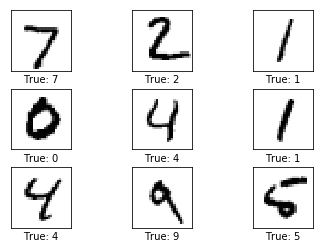

In [96]:
images = data.test.images[0:9]

cls_true = data.test.cls[0:9]

plot_images(images=images, cls_true=cls_true)

In [14]:
x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='x')
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])
y_true = tf.placeholder(tf.float32, shape=[None, 10], name='y_true')
y_true_cls = tf.argmax(y_true, dimension=1)

## NN with PT

In [15]:
x_pt=pt.wrap(x_image)

In [16]:
with pt.defaults_scope(activation_fn=tf.nn.relu):
    y_pred, loss= x_pt.\
        conv2d(kernel=5,depth=16,name="layer_1").\
        max_pool(kernel=2, stride=2).\
        conv2d(kernel=5,depth=36,name="layer_2").\
        max_pool(kernel=2, stride=2).\
        flatten().\
        fully_connected(size=128, name='layer_fc1').\
        softmax_classifier(num_classes=num_classes, labels=y_true)


In [17]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(loss)
y_pred_cls = tf.argmax(y_pred, dimension=1)
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver(max_to_keep=100)
save_dir = 'checkpoints/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
def get_save_path(net_number):
    return save_dir + 'network' + str(net_number)

In [18]:
session=tf.Session()

In [19]:
def init_variables():
    session.run(tf.initialize_all_variables())

In [20]:
tbs=64 #train batch size

In [21]:
def random_batch(x_train, y_train):
    num_images=len(x_train)
    idx=np.random.choice(num_images,size=tbs,replace=False)
    x_batch=x_train[idx, :]
    y_batch=y_train[idx, :]
    return x_batch, y_batch

In [22]:
def optimize(num_iterations, x_train, y_train):
    start_time = time.time()

    for i in range(num_iterations):

        x_batch, y_true_batch = random_batch(x_train, y_train)


        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}

        session.run(optimizer, feed_dict=feed_dict_train)

        if i % 100 == 0:
            acc = session.run(accuracy, feed_dict=feed_dict_train)
            
            msg = "Optimization Iteration: {0:>6}, Training Batch Accuracy: {1:>6.1%}"

            print(msg.format(i + 1, acc))

    end_time = time.time()

    time_dif = end_time - start_time

    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

In [23]:
n=5
ni=1000

In [24]:
if True:
    for i in range(n):
        print("NN: {0}".format(i))
        x_train,y_train, _, _=random_training_set()
        session.run(tf.global_variables_initializer())
        optimize(num_iterations=ni,
                x_train=x_train,
                y_train=y_train)
        saver.save(sess=session, save_path=get_save_path(i))
        print()

NN: 0
Optimization Iteration:      1, Training Batch Accuracy:  12.5%
Optimization Iteration:    101, Training Batch Accuracy:  79.7%
Optimization Iteration:    201, Training Batch Accuracy:  90.6%
Optimization Iteration:    301, Training Batch Accuracy:  90.6%
Optimization Iteration:    401, Training Batch Accuracy:  96.9%
Optimization Iteration:    501, Training Batch Accuracy:  93.8%
Optimization Iteration:    601, Training Batch Accuracy:  95.3%
Optimization Iteration:    701, Training Batch Accuracy:  96.9%
Optimization Iteration:    801, Training Batch Accuracy:  93.8%
Optimization Iteration:    901, Training Batch Accuracy:  96.9%
Time usage: 0:02:19

NN: 1
Optimization Iteration:      1, Training Batch Accuracy:   4.7%
Optimization Iteration:    101, Training Batch Accuracy:  82.8%
Optimization Iteration:    201, Training Batch Accuracy:  89.1%
Optimization Iteration:    301, Training Batch Accuracy:  92.2%
Optimization Iteration:    401, Training Batch Accuracy:  96.9%
Optimiz

batch_size=256
def predict_labels(images):
    num_images=len(images)
    pred_labels = np.zeros(shape=(num_images, num_classes),
                           dtype=np.float)
    i=0
    while i<num_images:
        j=min(i+batch_size, num_images)
        feed_dict={x:images[i:j, :]}
        pred_labels[i:j]=session.run(y_pred,feed_dict=feed_dict)
        i=j
    return pred_labels


In [26]:
def correct_prediction(images,labels,cls_true):
    pred_labels=predict_labels(images=images)
    cls_pred=np.argmax(pred_labels, axis=1)
    correct=(cls_true==cls_pred)
    return correct

In [27]:
def test_correct():
    return correct_prediction(images=data.test.images,
                             labels=data.test.labels,
                             cls_true=data.test.cls)
def validation_correct():
    return correct_prediction(images=data.validation.images,
                             labels=data.validation.labels,
                             cls_true=data.validation.cls)


In [35]:
def classification_accuracy(correct):
    return correct.mean()
def validation_accuracy():
    correct=validation_correct()
    return classification_accuracy(correct)
def test_accuracy():
    correct = test_correct()
    return classification_accuracy(correct)

def ensemble_predictions():
    pred_labels = []

    test_accuracies = []
    # Classification accuracy on the validation-set for each network.
    val_accuracies = []

    # For each neural network in the ensemble.
    for i in range(n):
        # Reload the variables into the TensorFlow graph.
        saver.restore(sess=session, save_path=get_save_path(i))

        # Calculate the classification accuracy on the test-set.
        test_acc = test_accuracy()

        # Append the classification accuracy to the list.
        test_accuracies.append(test_acc)

        # Calculate the classification accuracy on the validation-set.
        val_acc = validation_accuracy()

        # Append the classification accuracy to the list.
        val_accuracies.append(val_acc)

        # Print status message.
        msg = "Network: {0}, Accuracy on Validation-Set: {1:.4f}, Test-Set: {2:.4f}"
        print(msg.format(i, val_acc, test_acc))

        # Calculate the predicted labels for the images in the test-set.
        # This is already calculated in test_accuracy() above but
        # it is re-calculated here to keep the code a bit simpler.
        pred = predict_labels(images=data.test.images)

        # Append the predicted labels to the list.
        pred_labels.append(pred)
    
    return np.array(pred_labels), \
           np.array(test_accuracies), \
           np.array(val_accuracies)

In [37]:
pred_labels, test_accuracies, val_accuracies = ensemble_predictions()

Network: 0, Accuracy on Validation-Set: 0.9712, Test-Set: 0.9660
Network: 1, Accuracy on Validation-Set: 0.9720, Test-Set: 0.9699
Network: 2, Accuracy on Validation-Set: 0.9692, Test-Set: 0.9681
Network: 3, Accuracy on Validation-Set: 0.9690, Test-Set: 0.9665
Network: 4, Accuracy on Validation-Set: 0.9684, Test-Set: 0.9666


In [38]:
print("Mean test-set accuracy: {0:.4f}".format(np.mean(test_accuracies)))
print("Min test-set accuracy:  {0:.4f}".format(np.min(test_accuracies)))
print("Max test-set accuracy:  {0:.4f}".format(np.max(test_accuracies)))

Mean test-set accuracy: 0.9674
Min test-set accuracy:  0.9660
Max test-set accuracy:  0.9699


In [33]:
pred_labels.shape


(1, 10000, 10)

In [32]:
ensemble_pred_labels = np.mean(pred_labels, axis=0)
ensemble_pred_labels.shape

(10000, 10)

In [70]:
ensemble_cls_pred = np.argmax(ensemble_pred_labels, axis=1)
ensemble_cls_pred.shape
ensemble_correct = (ensemble_cls_pred == data.test.cls)
ensemble_incorrect = np.logical_not(ensemble_correct)

In [71]:
test_accuracies

array([ 0.966 ,  0.9699,  0.9681,  0.9665,  0.9666])

In [72]:
best_net=np.argmax(test_accuracies)

In [73]:
best_net

1

In [74]:
test_accuracies[best_net]

0.96989999999999998

In [75]:
bnpl= pred_labels[best_net, :, :]

In [76]:
bncp=np.argmax(bnpl,axis=1)

In [77]:
bnc=(bncp==data.test.cls)

In [78]:
bnic=np.logical_not(bnc)

In [79]:
np.sum(ensemble_correct)

9660

In [80]:
np.sum(bnc)

9699

In [81]:
enb=np.logical_and(bnic, ensemble_correct)

In [82]:
enb.sum()

87

In [83]:
bnb=np.logical_and(bnc, ensemble_incorrect)

In [84]:
bnb.sum()


126

## though the best_net is better than ensemble right now but of i would've increased the number of iterations then the ensemble would've been better

In [90]:
def pic(idx):
    plot_images(images=data.test.images[idx, :],
                cls_true=data.test.cls[idx],
                ensemble_cls_pred=ensemble_cls_pred[idx],
                best_cls_pred=bncp[idx])

In [91]:
def print_labels(labels, idx, num=1):
    labels=labels[idx, :]
    labels=labels[0:num, :]
    labels_rounded=np.round(labels,2)
    print(labels_rounded)

In [92]:
def ple(idx, **kwargs):
    print_labels(labels=bnpl,idx=idx, **kwargs)

In [93]:
def pln(idx):
    for i in range(nu):
        print_labels(labels=pred_labels[i, :, :], idx=idx, num=1)

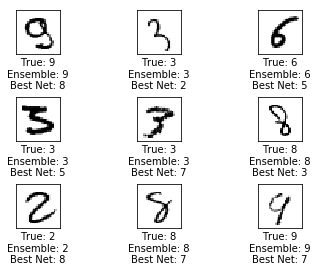

In [97]:
pic(idx=enb)

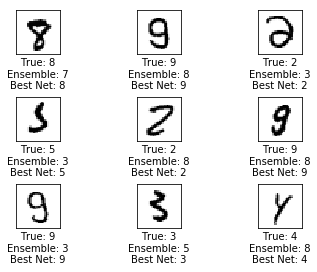

In [98]:
pic(idx=bnb)

In [100]:
session.close()